# ADS 599: Retail Dataset Capstone Project
#### By Jesse Gutierrez, Verity Pierson, & Sultan Mahmud Rahat

##### Load Req. Packages

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

2024-08-10 22:07:53.374817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### While the dataset is complete containing all necessary attributes, we want to mimic data sources as expected to be found. Therefore, we split the data into subsets and assigned primary/foreign keys based on what would be anticipated.

In [3]:
# Load csv file downloaded from kaggle
df = pd.read_csv("Datasets/retail_data.csv")

# Display output
df.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,...,324.086270,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts
1,2174773.0,69749.0,Kelsey Hill,Mark36@gmail.com,6.852900e+09,82072 Dawn Centers,Nottingham,England,99071.0,UK,...,806.707815,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.0,Lenovo Tab
2,6679610.0,30192.0,Scott Jensen,Shane85@gmail.com,8.362160e+09,4133 Young Canyon,Geelong,New South Wales,75929.0,Australia,...,1063.432799,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.0,Sports equipment
3,7232460.0,62101.0,Joseph Miller,Mary34@gmail.com,2.776752e+09,8148 Thomas Creek Suite 100,Edmonton,Ontario,88420.0,Canada,...,2466.854021,Home Decor,Home Depot,Tools,Excellent,Standard,PayPal,Processing,4.0,Utility knife
4,4983775.0,27901.0,Debra Coleman,Charles30@gmail.com,9.098268e+09,5813 Lori Ports Suite 269,Bristol,England,48704.0,UK,...,248.553049,Grocery,Nestle,Chocolate,Bad,Standard,Cash,Shipped,1.0,Chocolate cookies


In [4]:
# Subset data based on data sources (receiving, sales, website, etc.)
customer_info = df[['Customer_ID', 'Name', 'Email', 'Phone', 'Address', 'City', 'State', 'Zipcode', 'Country', 'Age', 'Gender', 'Income', 'Customer_Segment']]
transaction_details = df[['Transaction_ID', 'Customer_ID', 'Date', 'Year', 'Month', 'Time', 'Total_Purchases', 'Amount', 'Total_Amount']]
transaction_logistics = df[['Transaction_ID', 'Shipping_Method', 'Payment_Method', 'Order_Status']]

# Generate Product_ID for each unique product w/ leading zeros
unique_products = df['products'].unique()
product_mapping = {product: f'P{idx:03}' for idx, product in enumerate(unique_products)}

# Map the Product_IDs back to the dataframe
df['Product_ID'] = df['products'].map(product_mapping)

# Create product_info w/ Product_ID & Transaction_ID
product_info = df[['Product_ID', 'Transaction_ID', 'Product_Category', 'Product_Brand', 'Product_Type', 'products']]

# Add Product_ID to feedback
feedback = df[['Product_ID', 'Feedback', 'Ratings']]

# Verify the data
customer_info.head()

,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment
0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,21.0,Male,Low,Regular
1,69749.0,Kelsey Hill,Mark36@gmail.com,6.852900e+09,82072 Dawn Centers,Nottingham,England,99071.0,UK,19.0,Female,Low,Premium
2,30192.0,Scott Jensen,Shane85@gmail.com,8.362160e+09,4133 Young Canyon,Geelong,New South Wales,75929.0,Australia,48.0,Male,Low,Regular
3,62101.0,Joseph Miller,Mary34@gmail.com,2.776752e+09,8148 Thomas Creek Suite 100,Edmonton,Ontario,88420.0,Canada,56.0,Male,High,Premium
4,27901.0,Debra Coleman,Charles30@gmail.com,9.098268e+09,5813 Lori Ports Suite 269,Bristol,England,48704.0,UK,22.0,Male,Low,Premium


In [5]:
# Display the range of Product_IDs
product_ids = df['Product_ID'].unique()
print("Range of Product_IDs:", min(product_ids), "to", max(product_ids))

# Count of unique Product_IDs
print("Total unique Product_IDs:", len(product_ids))

# Verify the number of unique products
print("Total unique products:", len(unique_products))

Range of Product_IDs: P000 to P317
Total unique Product_IDs: 318
Total unique products: 318


In [7]:
# Save customer_info subset to CSV
customer_info.to_csv('/Users/jesse/Desktop/School/University of San Diego/ADS 599- Capstone/Retail_Analysis/Datasets/customer_info.csv', index=False)

# Save transaction_details subset to CSV
transaction_details.to_csv('/Users/jesse/Desktop/School/University of San Diego/ADS 599- Capstone/Retail_Analysis/Datasets/transaction_details.csv', index=False)

# Save transaction_logistics subset to CSV
transaction_logistics.to_csv('/Users/jesse/Desktop/School/University of San Diego/ADS 599- Capstone/Retail_Analysis/Datasets/transaction_logistics.csv', index=False)

# Save product_info subset to CSV
product_info.to_csv('/Users/jesse/Desktop/School/University of San Diego/ADS 599- Capstone/Retail_Analysis/Datasets/product_info.csv', index=False)

# Save feedback subset to CSV
feedback.to_csv('/Users/jesse/Desktop/School/University of San Diego/ADS 599- Capstone/Retail_Analysis/Datasets/feedback.csv', index=False)

# Confirm output
print("CSV files saved successfully.")

CSV files saved successfully.


#### Once the data has been split, we are going to use a local database using SQLite

In [6]:
# Pathway to the datasets
datasets_path = '/Users/jesse/Desktop/School/University of San Diego/ADS 599- Capstone/Retail_Analysis/Datasets/'

# CSV files
csv_files = {
    'customer_info': 'customer_info.csv',
    'transaction_details': 'transaction_details.csv',
    'product_info': 'product_info.csv',
    'feedback': 'feedback.csv',
    'transaction_logistics': 'transaction_logistics.csv'
}

# Create a connection to the SQLite database
conn = sqlite3.connect('retail_analysis.db')
cursor = conn.cursor()

# Load each CSV into the SQLite database
for table_name, csv_file in csv_files.items():
    df = pd.read_csv(datasets_path + csv_file)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"Loaded {csv_file} into table {table_name}")

# Fx to get column names & types
def get_table_info(table_name):
    query = f'PRAGMA table_info({table_name});'
    result = pd.read_sql_query(query, conn)
    return result[['name', 'type']]

# Get the list of table names
table_names_query = "SELECT name FROM sqlite_master WHERE type='table';"
table_names = pd.read_sql_query(table_names_query, conn)

# Print table names w/ column names & types
for table_name in table_names['name']:
    print(f"Table: {table_name}")
    table_info = get_table_info(table_name)
    print(table_info)
    print("\n")

# Close the connection
conn.close()

Loaded customer_info.csv into table customer_info
Loaded transaction_details.csv into table transaction_details
Loaded product_info.csv into table product_info
Loaded feedback.csv into table feedback
Loaded transaction_logistics.csv into table transaction_logistics
Table: customer_info
                name  type
0        Customer_ID  REAL
1               Name  TEXT
2              Email  TEXT
3              Phone  REAL
4            Address  TEXT
5               City  TEXT
6              State  TEXT
7            Zipcode  REAL
8            Country  TEXT
9                Age  REAL
10            Gender  TEXT
11            Income  TEXT
12  Customer_Segment  TEXT


Table: transaction_details
              name  type
0   Transaction_ID  REAL
1      Customer_ID  REAL
2             Date  TEXT
3             Year  REAL
4            Month  TEXT
5             Time  TEXT
6  Total_Purchases  REAL
7           Amount  REAL
8     Total_Amount  REAL


Table: product_info
               name  type
0       

#### Exploratory Data Analysis

In [7]:
# Connect to the database
conn = sqlite3.connect('retail_analysis.db')

# Load data into dataframes using pandas
customer_info = pd.read_sql_query("SELECT * FROM customer_info", conn)
transaction_details = pd.read_sql_query("SELECT * FROM transaction_details", conn)
transaction_logistics = pd.read_sql_query("SELECT * FROM transaction_logistics", conn)
product_info = pd.read_sql_query("SELECT * FROM product_info", conn)
feedback = pd.read_sql_query("SELECT * FROM feedback", conn)

In [8]:
# Check for null values
customer_info.isnull().sum()

Customer_ID         308
Name                382
Email               347
Phone               362
Address             315
City                248
State               281
Zipcode             340
Country             271
Age                 173
Gender              317
Income              290
Customer_Segment    215
dtype: int64

In [9]:
# Check for null values
transaction_details.isnull().sum()

Transaction_ID     333
Customer_ID        308
Date               359
Year               350
Month              273
Time               350
Total_Purchases    361
Amount             357
Total_Amount       350
dtype: int64

In [10]:
# Check for null values
transaction_logistics.isnull().sum()

Transaction_ID     333
Shipping_Method    337
Payment_Method     297
Order_Status       235
dtype: int64

In [11]:
# Check for null values
product_info.isnull().sum()

Product_ID            0
Transaction_ID      333
Product_Category    283
Product_Brand       281
Product_Type          0
products              0
dtype: int64

In [12]:
# Check for null values
feedback.isnull().sum()

Product_ID      0
Feedback      184
Ratings       184
dtype: int64

In [13]:
# Need to address null values, but want to see relative makeup

# List of table names
tables = ["customer_info", "transaction_details", "transaction_logistics", "product_info", "feedback"]

# Dictionary to store dataframes
dataframes = {}

# Load data into dataframes
for table in tables:
    dataframes[table] = pd.read_sql_query(f"SELECT * FROM {table}", conn)

# Function to count null values per row
def count_nulls_per_row(df):
    return df.isnull().sum(axis=1).value_counts().sort_index()

# Loop through each dataframe to find rows with null values and calculate percentages
for table, df in dataframes.items():
    total_rows = len(df)
    null_rows = df.isnull().any(axis=1).sum()
    non_null_percentage = ((total_rows - null_rows) / total_rows) * 100
    
    # Get count of nulls per row
    null_counts = count_nulls_per_row(df)
    
    print(f"Table: {table}")
    print(f"Rows with at least one null value: {null_rows}")
    print(f"Percentage of non-null rows: {non_null_percentage:.2f}%")
    print(f"Null values per row count:\n{null_counts}\n")

Table: customer_info
Rows with at least one null value: 3827
Percentage of non-null rows: 98.73%
Null values per row count:
0    298183
1      3805
2        22
Name: count, dtype: int64

Table: transaction_details
Rows with at least one null value: 3026
Percentage of non-null rows: 99.00%
Null values per row count:
0    298984
1      3011
2        15
Name: count, dtype: int64

Table: transaction_logistics
Rows with at least one null value: 1202
Percentage of non-null rows: 99.60%
Null values per row count:
0    300808
1      1202
Name: count, dtype: int64

Table: product_info
Rows with at least one null value: 894
Percentage of non-null rows: 99.70%
Null values per row count:
0    301116
1       891
2         3
Name: count, dtype: int64

Table: feedback
Rows with at least one null value: 184
Percentage of non-null rows: 99.94%
Null values per row count:
0    301826
2       184
Name: count, dtype: int64



In [14]:
# Since we do have a large dataset for this given problem, we will remove all null values amounting to ≤1.73% of the dataset

# Dictionary to store dataframes
dataframes = {}

# Load data into dataframes
for table in tables:
    dataframes[table] = pd.read_sql_query(f"SELECT * FROM {table}", conn)

# Loop through each dataframe to drop rows with null values
for table, df in dataframes.items():
    # Drop rows with any null values
    df_cleaned = df.dropna()
    
    # Update the dictionary with the cleaned dataframe
    dataframes[table] = df_cleaned
    
    print(f"Table: {table}")
    print(f"Original rows: {len(df)}")
    print(f"Rows after dropping null values: {len(df_cleaned)}\n")

Table: customer_info
Original rows: 302010
Rows after dropping null values: 298183

Table: transaction_details
Original rows: 302010
Rows after dropping null values: 298984

Table: transaction_logistics
Original rows: 302010
Rows after dropping null values: 300808

Table: product_info
Original rows: 302010
Rows after dropping null values: 301116

Table: feedback
Original rows: 302010
Rows after dropping null values: 301826



In [15]:
# Display desc. stats
customer_info.describe()

,Customer_ID,Phone,Zipcode,Age
count,301702.000000,3.016480e+05,301670.000000,301837.000000
mean,55006.553934,5.501464e+09,50298.951019,35.481326
std,26005.675200,2.596017e+09,28972.807134,15.021933
min,10000.000000,1.000049e+09,501.000000,18.000000
25%,32469.250000,3.255061e+09,25425.000000,22.000000
50%,55012.000000,5.505812e+09,50602.500000,32.000000
75%,77511.000000,7.749860e+09,75252.000000,46.000000
max,99999.000000,9.999996e+09,99949.000000,70.000000


In [16]:
# Display desc. stats
transaction_details.describe()

,Transaction_ID,Customer_ID,Year,Total_Purchases,Amount,Total_Amount
count,3.016770e+05,301702.000000,301660.000000,301649.000000,301653.000000,301660.000000
mean,5.495823e+06,55006.553934,2023.165113,5.359729,255.163659,1367.651156
std,2.595565e+06,26005.675200,0.371283,2.868575,141.389640,1128.998515
min,1.000007e+06,10000.000000,2023.000000,1.000000,10.000219,10.003750
25%,3.247930e+06,32469.250000,2023.000000,3.000000,132.890764,438.724278
50%,5.499657e+06,55012.000000,2023.000000,5.000000,255.470969,1041.117547
75%,7.739509e+06,77511.000000,2023.000000,8.000000,377.672606,2029.999853
max,9.999995e+06,99999.000000,2024.000000,10.000000,499.997911,4999.625796


In [17]:
# Display desc. stats
feedback.describe()

,Ratings
count,301826.000000
mean,3.162670
std,1.320827
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


## Customer Information

In [18]:
# Customer location
country_percentage = customer_info['Country'].value_counts(normalize=True) * 100

# Display results
country_percentage

Country
USA          31.558068
UK           20.900845
Germany      17.508509
Australia    15.019272
Canada       15.013306
Name: proportion, dtype: float64

In [19]:
# What are the total transaction per the lifetime of a customer?
average_transactions_per_customer = transaction_details.groupby('Customer_ID')['Transaction_ID'].count().mean()
average_transactions_per_customer =average_transactions_per_customer.round(2)

# Display results
print(f"What are the total transaction per the lifetime of a customer? {average_transactions_per_customer}")

What are the total transaction per the lifetime of a customer? 3.47


In [20]:
# Merge transaction_details & customer_info on Customer_ID
merged_df_transactions = pd.merge(transaction_details, customer_info, on='Customer_ID')

# Group by Country & calculate average transactions per customer
avg_transactions_by_country = merged_df_transactions.groupby('Country').agg({
    'Transaction_ID': 'count',
    'Customer_ID': 'nunique'
}).reset_index()

avg_transactions_by_country['Avg_Transactions_Per_Customer'] = (
    avg_transactions_by_country['Transaction_ID'] / avg_transactions_by_country['Customer_ID']
).round(2)

# Display results
print("Average transactions per customer by country:")
print(avg_transactions_by_country[['Country', 'Avg_Transactions_Per_Customer']])

Average transactions per customer by country:
     Country  Avg_Transactions_Per_Customer
0  Australia                           5.90
1     Canada                           6.04
2    Germany                           6.26
3         UK                           6.54
4        USA                           7.63


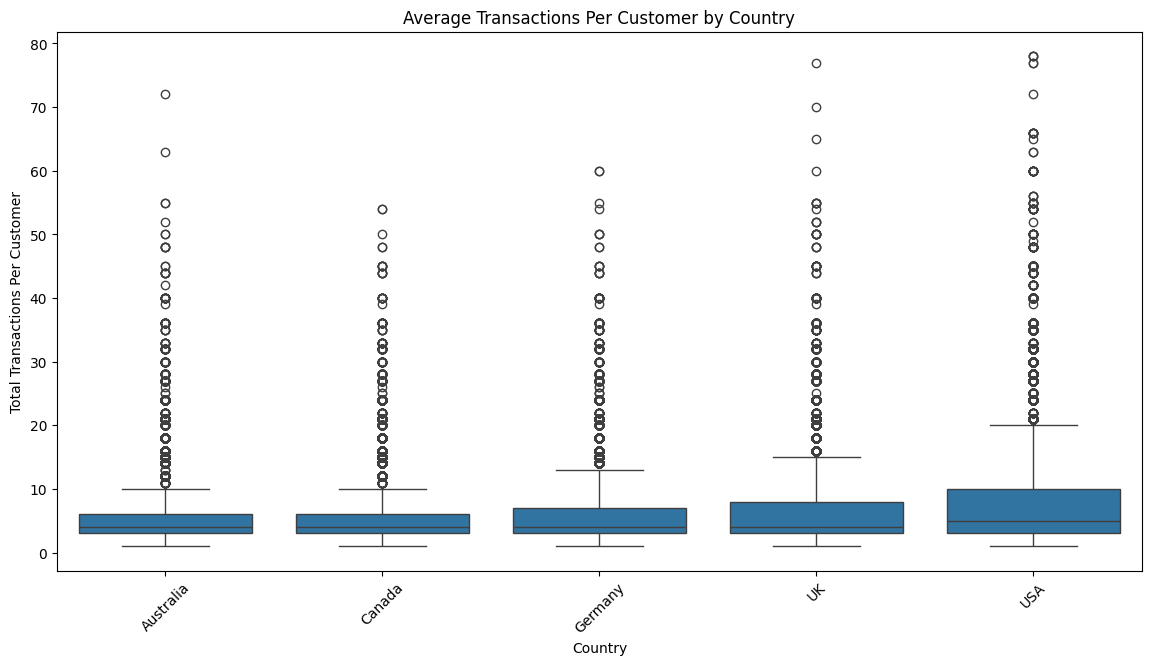

In [21]:
# Calculate total transactions per customer
transactions_per_customer = merged_df_transactions.groupby(['Country', 'Customer_ID']).size().reset_index(name='Total_Transactions')

# Box plot
plt.figure(figsize=(14, 7))
sns.boxplot(x='Country', y='Total_Transactions', data=transactions_per_customer)
plt.title('Average Transactions Per Customer by Country')
plt.xlabel('Country')
plt.ylabel('Total Transactions Per Customer')
plt.xticks(rotation=45)
plt.show()

In [22]:
# How many items does a customer get per transaction?
average_products_per_transaction = transaction_details['Total_Purchases'].mean()
average_products_per_transaction = average_products_per_transaction.round(2)

# Display results
print(f"How many items does a customer get per transaction? {average_products_per_transaction}")

How many items does a customer get per transaction? 5.36


In [23]:
# Merge transaction_details 2/ customer_info on Customer_ID
merged_df_products = pd.merge(transaction_details, customer_info, on='Customer_ID')

# Group by Country & calculate average products per transaction
avg_products_by_country = merged_df_products.groupby('Country')['Total_Purchases'].mean().reset_index()
avg_products_by_country['Total_Purchases'] = avg_products_by_country['Total_Purchases'].round(2)

# Display results
print("Average items per transaction by country:")
print(avg_products_by_country[['Country', 'Total_Purchases']])

Average items per transaction by country:
     Country  Total_Purchases
0  Australia             5.37
1     Canada             5.37
2    Germany             5.36
3         UK             5.38
4        USA             5.36


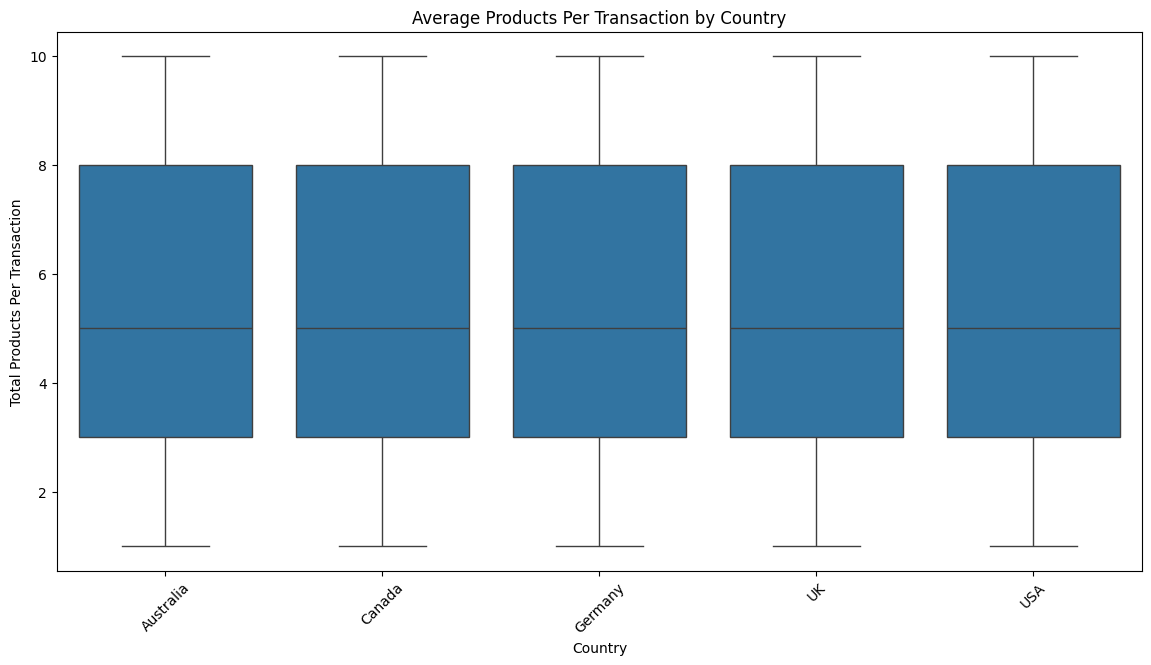

In [24]:
# Group by Country & calculate average products per transaction
products_per_transaction = merged_df_products.groupby(['Country', 'Transaction_ID'])['Total_Purchases'].mean().reset_index()

# Plotting
plt.figure(figsize=(14, 7))
sns.boxplot(x='Country', y='Total_Purchases', data=products_per_transaction)
plt.title('Average Products Per Transaction by Country')
plt.xlabel('Country')
plt.ylabel('Total Products Per Transaction')
plt.xticks(rotation=45)
plt.show()

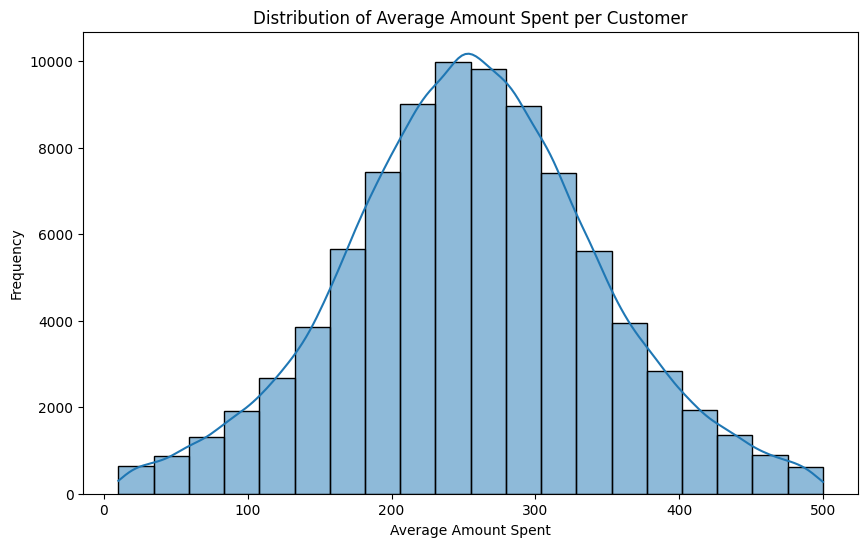

In [25]:
# Amount spent per transaction
plt.figure(figsize=(10, 6))
sns.histplot(transaction_details.groupby('Customer_ID')['Amount'].mean(), bins=20, kde=True)
plt.title('Distribution of Average Amount Spent per Customer')
plt.xlabel('Average Amount Spent')
plt.ylabel('Frequency')
plt.show()

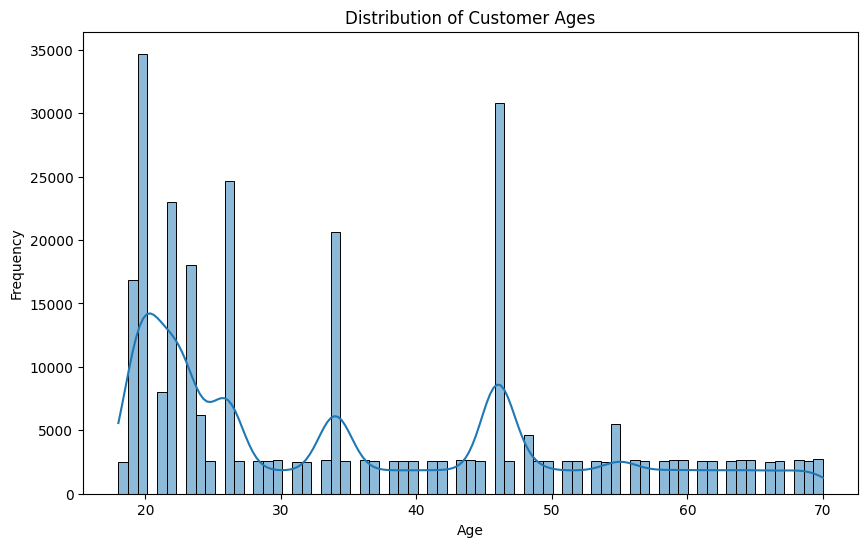

In [26]:
# Distribution of Customer Ages
plt.figure(figsize=(10, 6))
sns.histplot(customer_info['Age'], kde=True)
plt.title('Distribution of Customer Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

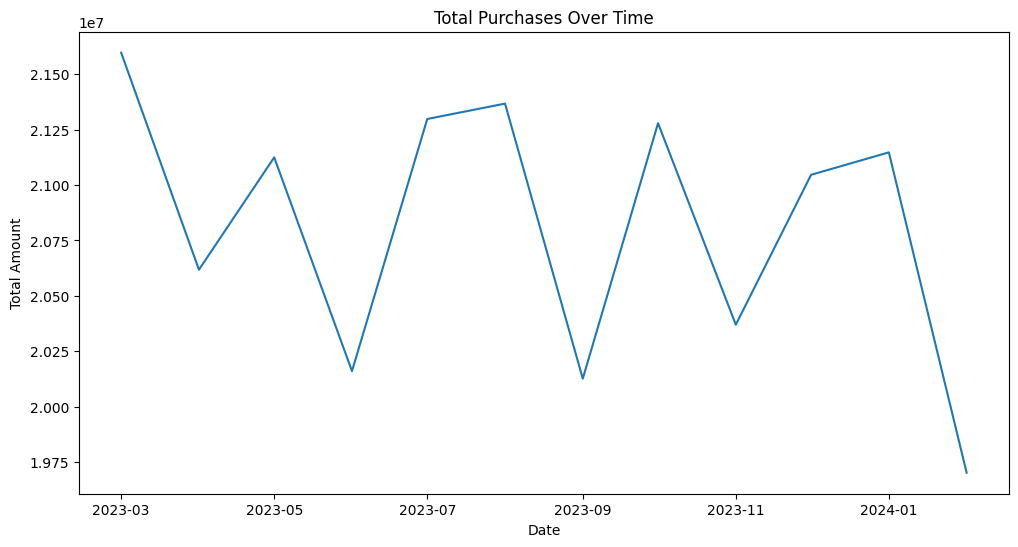

In [28]:
# Total Purchases Over Time

# Correct date parsing w/ error handling
transaction_details['Date'] = pd.to_datetime(transaction_details['Date'], errors='coerce')

# Drop rows w/ invalid dates
transaction_details = transaction_details.dropna(subset=['Date'])

# Group by month & sum the total amount
transaction_details['Month'] = transaction_details['Date'].dt.to_period('M')
monthly_sales = transaction_details.groupby('Month').agg({'Total_Amount': 'sum'}).reset_index()
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Total_Amount', data=monthly_sales)
plt.title('Total Purchases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.show()

In [29]:
# Calculate the number of unique product categories, brands, and types
num_unique_categories = product_info['Product_Category'].nunique()
num_unique_brands = product_info['Product_Brand'].nunique()
num_unique_types = product_info['Product_Type'].nunique()

# Display the results
print(f"Number of unique product categories: {num_unique_categories}")
print(f"Number of unique product brands: {num_unique_brands}")
print(f"Number of unique product types: {num_unique_types}")

Number of unique product categories: 5
Number of unique product brands: 18
Number of unique product types: 33


In [30]:
# Get the unique values
unique_categories = product_info['Product_Category'].unique()
unique_brands = product_info['Product_Brand'].unique()
unique_types = product_info['Product_Type'].unique()

# Display the unique values
print("Unique product categories:")
print(unique_categories)

print("\nUnique product brands:")
print(unique_brands)

print("\nUnique product types:")
print(unique_types)

Unique product categories:
['Clothing' 'Electronics' 'Books' 'Home Decor' 'Grocery' None]

Unique product brands:
['Nike' 'Samsung' 'Penguin Books' 'Home Depot' 'Nestle' 'Apple' 'Zara'
 'Random House' 'Coca-Cola' 'Adidas' 'Pepsi' 'IKEA' 'HarperCollins'
 'Bed Bath & Beyond' 'Sony' None 'Whirepool' 'Mitsubhisi' 'BlueStar']

Unique product types:
['Shorts' 'Tablet' "Children's" 'Tools' 'Chocolate' 'Television' 'Shirt'
 'Decorations' 'Non-Fiction' 'Water' 'Snacks' 'T-shirt' 'Literature'
 'Juice' 'Furniture' 'Coffee' 'Bathroom' 'Kitchen' 'Smartphone' 'Shoes'
 'Thriller' 'Soft Drink' 'Laptop' 'Dress' 'Headphones' 'Lighting'
 'Bedding' 'Jacket' 'Fiction' 'Jeans' 'Fridge'
 'Mitsubishi 1.5 Ton 3 Star Split AC' 'BlueStar AC']


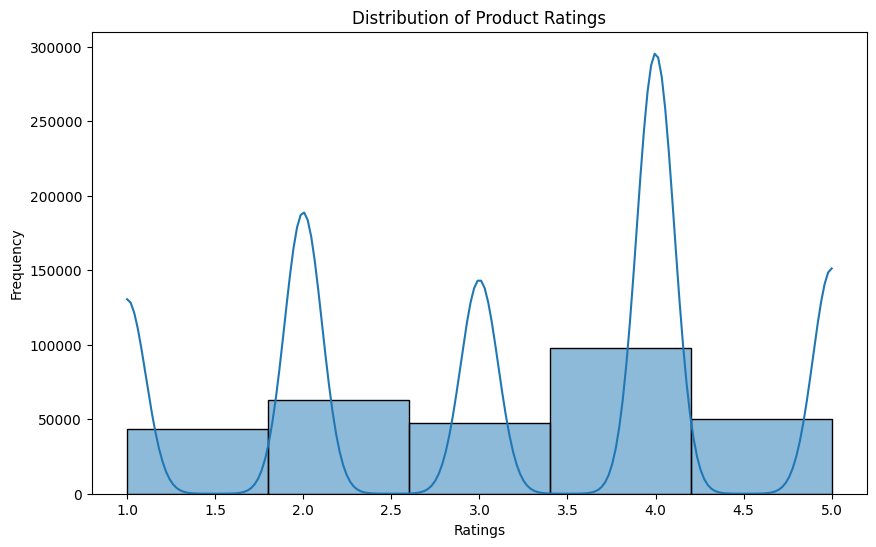

In [29]:
# Product Ratings Distribution
plt.figure(figsize=(10, 6))
sns.histplot(feedback['Ratings'], bins=5, kde=True)
plt.title('Distribution of Product Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

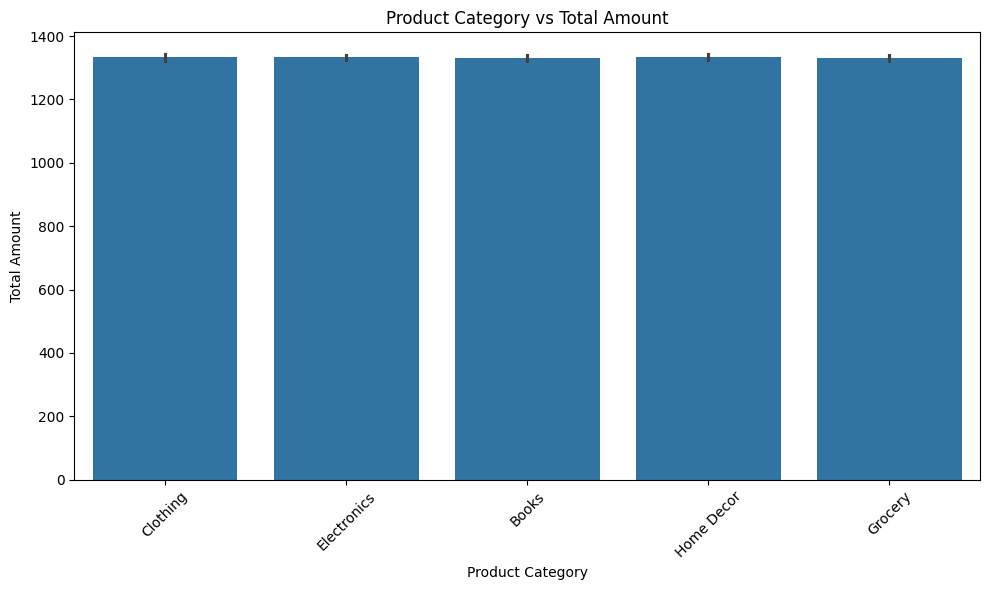

In [31]:
# Sales by Product Category

# Merge transaction_details with product_info on Product_ID
merged_data = pd.merge(transaction_details, product_info, on='Transaction_ID', how='inner')

# Plotting Product_Category vs Total_Amount
plt.figure(figsize=(10, 6))
sns.barplot(x='Product_Category', y='Total_Amount', data=merged_data)
plt.title('Product Category vs Total Amount')
plt.xlabel('Product Category')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

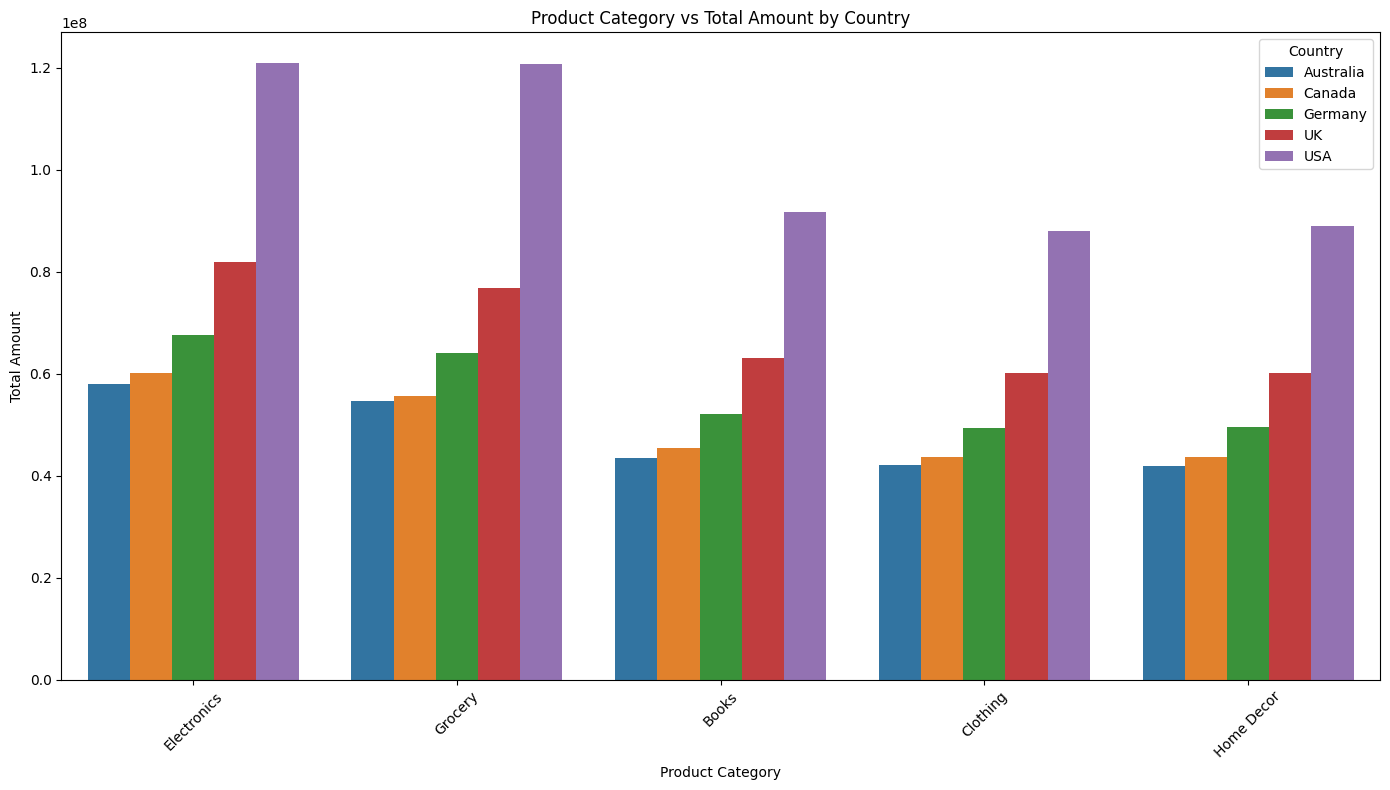

In [32]:
# Merge transaction_details w/ customer_info and product_info
merged_data = pd.merge(transaction_details, customer_info, on='Customer_ID')
merged_data = pd.merge(merged_data, product_info, on='Transaction_ID')

# Group by Country & Product_Category to calculate total amount for each category
sales_by_category_country = merged_data.groupby(['Country', 'Product_Category'])['Total_Amount'].sum().reset_index()

# Sort the data by Country & Total_Amount w/in each country
sales_by_category_country = sales_by_category_country.sort_values(by=['Country', 'Total_Amount'], ascending=[True, False])

# Plotting Product_Category vs Total_Amount grouped by Country
plt.figure(figsize=(14, 8))
sns.barplot(x='Product_Category', y='Total_Amount', hue='Country', data=sales_by_category_country)
plt.title('Product Category vs Total Amount by Country')
plt.xlabel('Product Category')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.tight_layout()
plt.show()

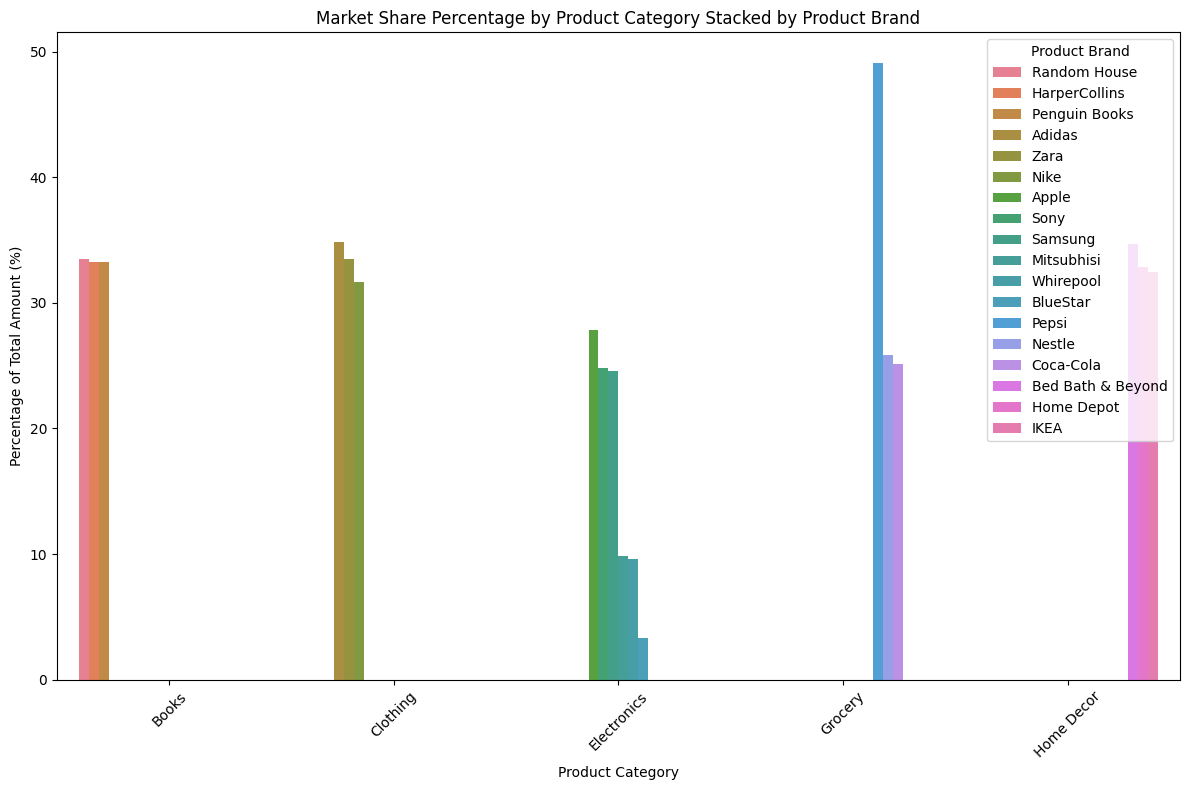

In [33]:
# Display market share

# Merge transaction_details w/ product_info merged on 'Transaction_ID'
merged_data = pd.merge(transaction_details, product_info, on='Transaction_ID', how='inner')

# Calculate total amount per Product_Category & Product_Brand
total_amount = merged_data.groupby(['Product_Category', 'Product_Brand'])['Total_Amount'].sum().reset_index()

# Calculate total amount per Product_Category
total_amount_category = total_amount.groupby('Product_Category')['Total_Amount'].sum().reset_index()

# Merge total_amount with total_amount_category to calculate percentage
total_amount = pd.merge(total_amount, total_amount_category, on='Product_Category', suffixes=('', '_total'))

# Calculate percentage of total amount within each Product_Category
total_amount['Percentage'] = 100 * total_amount['Total_Amount'] / total_amount['Total_Amount_total']

# Sort the data within each Product_Category by Percentage in descending order
total_amount.sort_values(['Product_Category', 'Percentage'], ascending=[True, False], inplace=True)

# Sort total_amount by Product_Category and Percentage
total_amount.sort_values(by=['Product_Category', 'Percentage'], ascending=[True, False], inplace=True)

# Plotting Product_Category vs Percentage of Total Amount stacked by Product_Brand
plt.figure(figsize=(12, 8))
sns.barplot(x='Product_Category', y='Percentage', hue='Product_Brand', data=total_amount)
plt.title('Market Share Percentage by Product Category Stacked by Product Brand')
plt.xlabel('Product Category')
plt.ylabel('Percentage of Total Amount (%)')
plt.xticks(rotation=45)
plt.legend(title='Product Brand', loc='upper right')
plt.tight_layout()
plt.show()

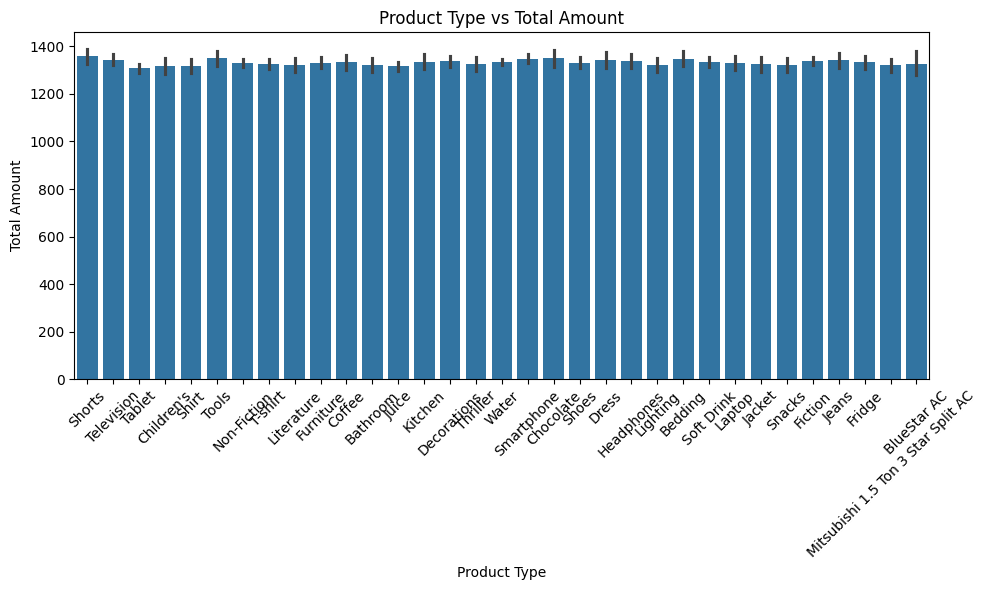

In [34]:
# Sales by Product Type

# Merge transaction_details with product_info on Product_ID
merged_data = pd.merge(transaction_details, product_info, on='Transaction_ID', how='inner')

# Plotting Product_Type vs Total_Amount
plt.figure(figsize=(10, 6))
sns.barplot(x='Product_Type', y='Total_Amount', data=merged_data)
plt.title('Product Type vs Total Amount')
plt.xlabel('Product Type')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

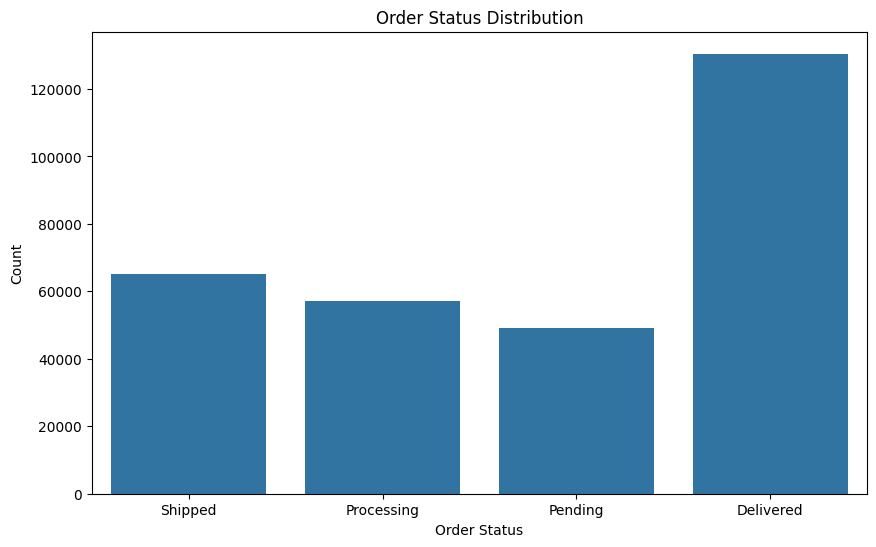

In [35]:
# Order Status Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Order_Status', data=transaction_logistics)
plt.title('Order Status Distribution')
plt.xlabel('Order Status')
plt.ylabel('Count')
plt.show()

In [35]:
#pip install mlxtend

In [36]:
# Association rule mining

from mlxtend.frequent_patterns import apriori, association_rules

# Merge transaction_details with product_info on Transaction_ID
merged_data = pd.merge(transaction_details, product_info, on='Transaction_ID', how='inner')

merged_data.head()

,Transaction_ID,Customer_ID,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_ID,Product_Category,Product_Brand,Product_Type,products
0,8691788.0,37249.0,2023-09-18,2023.0,2023-09,22:03:55,3.0,108.028757,324.086270,P000,Clothing,Nike,Shorts,Cycling shorts
1,8691788.0,37249.0,2023-09-18,2023.0,2023-09,22:03:55,3.0,108.028757,324.086270,P193,Electronics,Sony,Television,LED TV
2,2174773.0,69749.0,2023-12-31,2023.0,2023-12,8:42:04,2.0,403.353907,806.707815,P001,Electronics,Samsung,Tablet,Lenovo Tab
3,6679610.0,30192.0,2023-04-26,2023.0,2023-04,4:06:29,3.0,354.477600,1063.432799,P002,Books,Penguin Books,Children's,Sports equipment
4,6095326.0,41289.0,2023-09-21,2023.0,2023-09,23:24:27,4.0,296.291806,1185.167224,P001,Electronics,Apple,Tablet,Lenovo Tab


In [37]:
# Verify merged data and select necessary columns
basket = merged_data[['Transaction_ID', 'products']]

basket.head()

,Transaction_ID,products
0,8691788.0,Cycling shorts
1,8691788.0,LED TV
2,2174773.0,Lenovo Tab
3,6679610.0,Sports equipment
4,6095326.0,Lenovo Tab


In [38]:
# Pivot the data
basket = basket.pivot_table(index='Transaction_ID', columns='products', aggfunc='size', fill_value=0)

basket.head()

products,4K TV,A-line dress,Acer Iconia Tab,Acer Swift,Action,Adventure,Affogato,Air conditioner,Alkaline water,Amazon Fire Tablet,...,White chocolate,Wide-leg jeans,Windbreaker,Window AC,Wireless headphones,Wrap dress,Wrench,Xiaomi Mi,iPad,iPhone
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
1000007.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000043.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000154.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000219.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000294.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


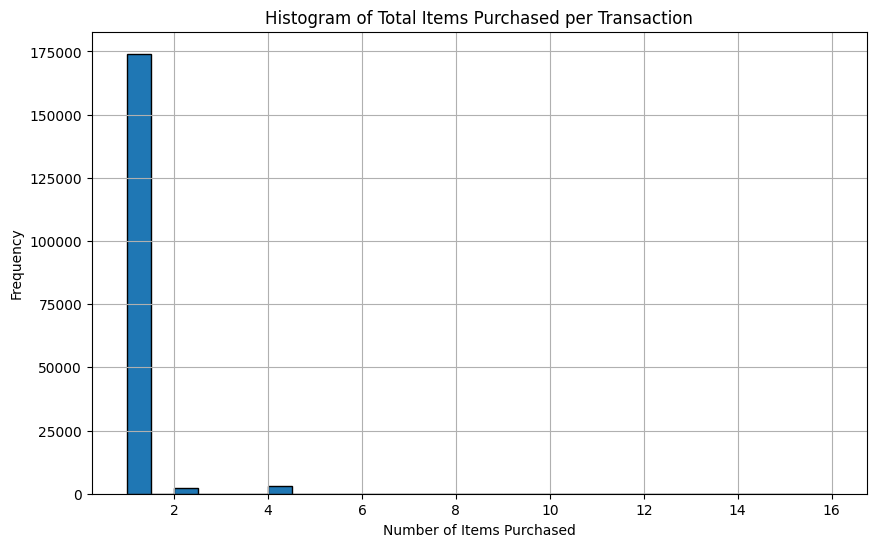

In [39]:
# Sum products purchased per transaction
items_per_transaction = basket.sum(axis=1)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(items_per_transaction, bins=30, edgecolor='black')
plt.xlabel('Number of Items Purchased')
plt.ylabel('Frequency')
plt.title('Histogram of Total Items Purchased per Transaction')
plt.grid(True)
plt.show()

In [40]:
# Calculate total purchases
basket['Total Purchases'] = basket.sum(axis=1)

# Count occurrences of each total purchase count
purchase_counts = basket['Total Purchases'].value_counts().sort_index()

# Print the counts for each number of products per transaction
print("Number of transactions by number of products:")
for count, num_transactions in purchase_counts.items():
    print(f"{count} products: {num_transactions} transactions")

Number of transactions by number of products:
1 products: 174078 transactions
2 products: 2233 transactions
3 products: 36 transactions
4 products: 3079 transactions
6 products: 44 transactions
9 products: 28 transactions
16 products: 1 transactions


In [41]:
# Filter transactions w/ ≥ 2 products
basket_with_multiple_products = purchase_counts = basket[basket['Total Purchases'] >= 2]

# Drop the Total Purchases column to not include in results
basket_with_multiple_products = basket_with_multiple_products.drop(columns=['Total Purchases'])

# Ensure dummy variables are correctly set for products
basket_with_multiple_products = basket_with_multiple_products.astype(bool).astype(int)

# Apply association rule mining
frequent_itemsets = apriori(basket_with_multiple_products, min_support=0.001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=.8)

# Sorting rules by lift in descending order
rules_sorted = rules.sort_values(by='lift', ascending=False)

# Displaying the top rules
print("Top 10 Association Rules by Lift:")
rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

/Users/jesse/opt/anaconda3/envs/APS/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Top 10 Association Rules by Lift:


,antecedents,consequents,support,confidence,lift
4,(Huawei MediaPad),(Google Pixel Slate),0.001107,0.142857,11.733766
5,(Google Pixel Slate),(Huawei MediaPad),0.001107,0.090909,11.733766
0,(Memoir),(Cooking),0.001107,0.115385,8.568493
1,(Cooking),(Memoir),0.001107,0.082192,8.568493
8,(iPhone),(Sony Xperia),0.001291,0.092105,5.944079
9,(Sony Xperia),(iPhone),0.001291,0.083333,5.944079
3,(Science),(Cooking),0.001107,0.075000,5.569521
2,(Cooking),(Science),0.001107,0.082192,5.569521
6,(History),(Psychology),0.001107,0.061856,5.004770
7,(Psychology),(History),0.001107,0.089552,5.004770


Rule 4: (Huawei MediaPad) -> (Google Pixel Slate)

Support: 0.001107

This means that 0.1107% of all transactions contain both Huawei MediaPad and Google Pixel Slate.

Confidence: 0.142857

Among all transactions that contain Huawei MediaPad, 14.29% also contain Google Pixel Slate.

Lift: 11.733766

Transactions containing Huawei MediaPad are about 11.73 times more likely to also contain Google Pixel Slate compared to transactions in general.

# Model Building

In [42]:
# Merge dataframes to create a unified dataset
data = transaction_details.merge(product_info, on='Transaction_ID', how='left')
data = data.merge(customer_info, on='Customer_ID', how='left')

# Display dimensions
data.shape

(1217851, 26)

In [43]:
# Select relevant features for the recommendation system
features = data[['Customer_ID', 'Product_ID', 'Product_Category', 'Product_Brand', 'Product_Type', 'Total_Amount']]

# Display the first few rows of the feature set
features.head()

,Customer_ID,Product_ID,Product_Category,Product_Brand,Product_Type,Total_Amount
0,37249.0,P000,Clothing,Nike,Shorts,324.08627
1,37249.0,P000,Clothing,Nike,Shorts,324.08627
2,37249.0,P000,Clothing,Nike,Shorts,324.08627
3,37249.0,P000,Clothing,Nike,Shorts,324.08627
4,37249.0,P000,Clothing,Nike,Shorts,324.08627


# Model Training

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import mlxtend.frequent_patterns as fp

# Create a user-item interaction matrix
user_item_matrix = features.pivot_table(index='Customer_ID', columns='Product_ID', values='Total_Amount', fill_value=0)

# Split the data into training and testing sets
train_data, test_data = train_test_split(user_item_matrix, test_size=0.2, random_state=42)

In [70]:
# Define a custom scorer for reconstruction error
def reconstruction_error(estimator, X):
    transformed = estimator.transform(X)
    reconstructed = np.dot(transformed, estimator.components_)
    return -mean_squared_error(X, reconstructed)

## Matrix Factorization (using SVD)

In [ ]:
# Apply Matrix Factorization using Truncated SVD
svd = TruncatedSVD(n_components=50, random_state=42)
train_svd = svd.fit_transform(train_data)
test_svd = svd.transform(test_data)

# Reconstruct the user-item interaction matrix
train_reconstructed = np.dot(train_svd, svd.components_)
test_reconstructed = np.dot(test_svd, svd.components_)

# Calculate the RMSE for the test set
rmse = np.sqrt(mean_squared_error(test_data, test_reconstructed))
print(f'RMSE: {rmse}')

In [73]:
custom_scorer = make_scorer(reconstruction_error, greater_is_better=False)

# Hyperparameter tuning for SVD
param_grid = {'n_components': [20, 50, 100]}
grid_search = GridSearchCV(TruncatedSVD(random_state=42), param_grid, cv=3, scoring=custom_scorer)
grid_search.fit(train_data)

# Best parameter for SVD
best_svd = grid_search.best_estimator_

# Apply the best SVD
train_svd = best_svd.fit_transform(train_data)
test_svd = best_svd.transform(test_data)

# Reconstruct the user-item interaction matrix
train_reconstructed = np.dot(train_svd, best_svd.components_)
test_reconstructed = np.dot(test_svd, best_svd.components_)

# Evaluate the model
rmse_svd = np.sqrt(mean_squared_error(test_data, test_reconstructed))
mae_svd = mean_absolute_error(test_data, test_reconstructed)
r2_svd = r2_score(test_data, test_reconstructed)
print(f'Matrix Factorization (SVD) - RMSE: {rmse_svd}, MAE: {mae_svd}, R²: {r2_svd}')

# Print the best parameter
print(f'Best n_components: {grid_search.best_params_["n_components"]}')

# Calculate and print additional performance metrics
mse_svd = mean_squared_error(test_data, test_reconstructed)
explained_variance_svd = np.var(test_data - test_reconstructed) / np.var(test_data)

print(f'MSE: {mse_svd}')
print(f'Explained Variance: {explained_variance_svd}')

/Users/jesse/opt/anaconda3/envs/APS/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jesse/opt/anaconda3/envs/APS/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/jesse/opt/anaconda3/envs/APS/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jesse/opt/anaconda3/envs/APS/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_par

Matrix Factorization (SVD) - RMSE: 0.08136699183151583, MAE: 0.010715388561225985, R²: 0.2409728004399839
Best n_components: 20


/Users/jesse/opt/anaconda3/envs/APS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


MSE: 0.006620587359709964
Explained Variance: Product_ID
0      0.628641
1      0.722068
2      0.600287
3      0.560654
4      1.000175
         ...   
313    0.757580
314    0.662510
315    0.667227
316    1.003159
317    0.338174
Length: 318, dtype: float64


## K-Nearest Neighbors (KNN)

In [52]:
# Fit the KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(train_data)

# Predict the interaction matrix for the test set
distances, indices = knn.kneighbors(test_data, n_neighbors=len(train_data))

# Reconstruct the test set matrix using KNN
test_reconstructed_knn = np.zeros(test_data.shape)
for i in range(test_data.shape[0]):
    test_reconstructed_knn[i, :] = train_data.values[indices[i]].mean(axis=0)

# Calculate the RMSE for the test set
rmse_knn = np.sqrt(mean_squared_error(test_data, test_reconstructed_knn))
print(f'K-Nearest Neighbors RMSE: {rmse_knn}')

K-Nearest Neighbors RMSE: 165.84515361239437


In [62]:
# Encode user and product IDs
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

features['Customer_ID'] = user_encoder.fit_transform(features['Customer_ID'])
features['Product_ID'] = product_encoder.fit_transform(features['Product_ID'])

# Handle NaN values
features.dropna(inplace=True)

# Normalize Total_Amount
scaler = StandardScaler()
features['Total_Amount'] = scaler.fit_transform(features[['Total_Amount']])

# Create training and testing data
X = features[['Customer_ID', 'Product_ID']].values
y = features['Total_Amount'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
user_input = Input(shape=(1,))
product_input = Input(shape=(1,))

user_embedding = Embedding(input_dim=len(user_encoder.classes_), output_dim=50)(user_input)
product_embedding = Embedding(input_dim=len(product_encoder.classes_), output_dim=50)(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

merged_vector = Concatenate()([user_vector, product_vector])
dense_layer = Dense(128, activation='relu')(merged_vector)
output = Dense(1)(dense_layer)

model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=5, batch_size=64, validation_split=0.2)

# Predict the interaction matrix for the test set
y_pred = model.predict([X_test[:, 0], X_test[:, 1]])

# Calculate the RMSE for the test set
rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Deep Learning-based Recommendation System RMSE: {rmse_dl}')

/var/folders/gy/c9ysryks527gqrvc9m2d1pn80000gn/T/ipykernel_46837/2028384711.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Customer_ID'] = user_encoder.fit_transform(features['Customer_ID'])
/var/folders/gy/c9ysryks527gqrvc9m2d1pn80000gn/T/ipykernel_46837/2028384711.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Product_ID'] = product_encoder.fit_transform(features['Product_ID'])
/var/folders/gy/c9ysryks527gqrvc9m2d1pn80000gn/T/ipykernel_46837/2028384711.py:18: SettingWithCop

Epoch 1/5
12123/12123 ━━━━━━━━━━━━━━━━━━━━ 434s 36ms/step - loss: 0.6626 - val_loss: 0.3327
Epoch 2/5
12123/12123 ━━━━━━━━━━━━━━━━━━━━ 434s 36ms/step - loss: 0.2067 - val_loss: 0.1947
Epoch 3/5
12123/12123 ━━━━━━━━━━━━━━━━━━━━ 433s 36ms/step - loss: 0.1100 - val_loss: 0.1448
Epoch 4/5
12123/12123 ━━━━━━━━━━━━━━━━━━━━ 436s 36ms/step - loss: 0.0795 - val_loss: 0.1230
Epoch 5/5
12123/12123 ━━━━━━━━━━━━━━━━━━━━ 430s 35ms/step - loss: 0.0660 - val_loss: 0.1117
7577/7577 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Deep Learning-based Recommendation System RMSE: 0.3393895120681857


In [50]:
# Generate product recommendations for customers
def recommend_products(customer_id, user_item_matrix, svd, top_n=5):
    # Get the customer index
    customer_index = user_item_matrix.index.get_loc(customer_id)
    
    # Get the customer's interaction vector
    customer_vector = svd.transform(user_item_matrix.iloc[customer_index].values.reshape(1, -1))
    
    # Reconstruct the customer's interaction vector
    reconstructed_vector = np.dot(customer_vector, svd.components_)
    
    # Get the top N product recommendations
    recommendations = np.argsort(reconstructed_vector[0])[::-1][:top_n]
    
    # Get the product IDs of the top N recommendations
    product_ids = user_item_matrix.columns[recommendations]
    
    return product_ids

# Example: Recommend products for a specific customer
customer_id = 12345  # Replace with an actual customer ID
recommended_products = recommend_products(customer_id, user_item_matrix, svd)
print(f'Recommended Products for Customer {customer_id}: {recommended_products}')


RMSE: 127.49138800421407


# Take two

In [45]:

# Merge dataframes to create a unified dataset
data = transaction_details.merge(product_info, on='Transaction_ID', how='left')
data = data.merge(customer_info, on='Customer_ID', how='left')

# Select relevant features for the recommendation system
features = data[['Customer_ID', 'Product_ID', 'Total_Amount']]

# Create user-item interaction matrix
user_item_matrix = features.pivot_table(index='Customer_ID', columns='Product_ID', values='Total_Amount', fill_value=0)

# Check if the matrix is not empty
if user_item_matrix.shape[0] == 0 or user_item_matrix.shape[1] == 0:
    raise ValueError("User-item interaction matrix is empty. Please check your data.")

# Split the data into training and testing sets
train_data, test_data = train_test_split(user_item_matrix, test_size=0.2, random_state=42)

# Convert to sparse matrix format for efficiency
train_sparse = csr_matrix(train_data.values)
test_sparse = csr_matrix(test_data.values)

In [46]:
# Function to calculate precision at k
def precision_at_k(recommended_items, true_items, k):
    recommended_items_set = set(recommended_items[:k])
    true_items_set = set(true_items)
    return len(recommended_items_set & true_items_set) / k

# Function to calculate recall at k
def recall_at_k(recommended_items, true_items, k):
    recommended_items_set = set(recommended_items[:k])
    true_items_set = set(true_items)
    return len(recommended_items_set & true_items_set) / len(true_items_set)

# Convert the sparse matrix to dense format for compatibility with SVD
train_dense = train_sparse.toarray()
test_dense = test_sparse.toarray()

# Hyperparameter tuning for SVD
n_components_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
rmse_scores = []
precision_scores = []
recall_scores = []

for n_components in n_components_list:
    svd = TruncatedSVD(n_components=n_components)
    train_transformed = svd.fit_transform(train_dense)
    train_reconstructed = np.dot(train_transformed, svd.components_)
    
    # Evaluate the model on the test set
    test_transformed = svd.transform(test_dense)
    test_reconstructed = np.dot(test_transformed, svd.components_)
    rmse = np.sqrt(mean_squared_error(test_dense, test_reconstructed))
    rmse_scores.append(rmse)
    
    # Calculate Precision@k and Recall@k
    k = 5
    precision_at_k_scores = []
    recall_at_k_scores = []
    
    for user_index in range(test_dense.shape[0]):
        user_ratings = test_dense[user_index, :]
        true_items = np.where(user_ratings > 0)[0]
        
        if len(true_items) == 0:
            continue
        
        user_reconstructed = test_reconstructed[user_index, :]
        recommended_items = np.argsort(user_reconstructed)[::-1]
        
        precision = precision_at_k(recommended_items, true_items, k)
        recall = recall_at_k(recommended_items, true_items, k)
        
        precision_at_k_scores.append(precision)
        recall_at_k_scores.append(recall)
    
    mean_precision_at_k = np.mean(precision_at_k_scores)
    mean_recall_at_k = np.mean(recall_at_k_scores)
    precision_scores.append(mean_precision_at_k)
    recall_scores.append(mean_recall_at_k)
    
    print(f"SVD n_components={n_components}, RMSE={rmse}, Precision@{k}={mean_precision_at_k}, Recall@{k}={mean_recall_at_k}")

SVD n_components=5, RMSE=149.7204838892982, Precision@5=0.06023771281721812, Recall@5=0.12486982736498257
SVD n_components=10, RMSE=146.76618447790153, Precision@5=0.08057822036620622, Recall@5=0.16980114457545173
SVD n_components=15, RMSE=143.7470628750025, Precision@5=0.09376164471570833, Recall@5=0.19908020473790414
SVD n_components=20, RMSE=141.23174533168734, Precision@5=0.10731769996787666, Recall@5=0.22576813400533868
SVD n_components=25, RMSE=138.8286195548655, Precision@5=0.11712174751044009, Recall@5=0.24230628176256774
SVD n_components=30, RMSE=136.2914927570221, Precision@5=0.12552521683263732, Recall@5=0.2602735873270464
SVD n_components=35, RMSE=133.81458119868927, Precision@5=0.13956954706071314, Recall@5=0.29123545231717995
SVD n_components=40, RMSE=131.40920962176747, Precision@5=0.16513973658849984, Recall@5=0.357249708967479
SVD n_components=45, RMSE=129.38124128100893, Precision@5=0.19681336331513014, Recall@5=0.43062319649291
SVD n_components=50, RMSE=127.528180623

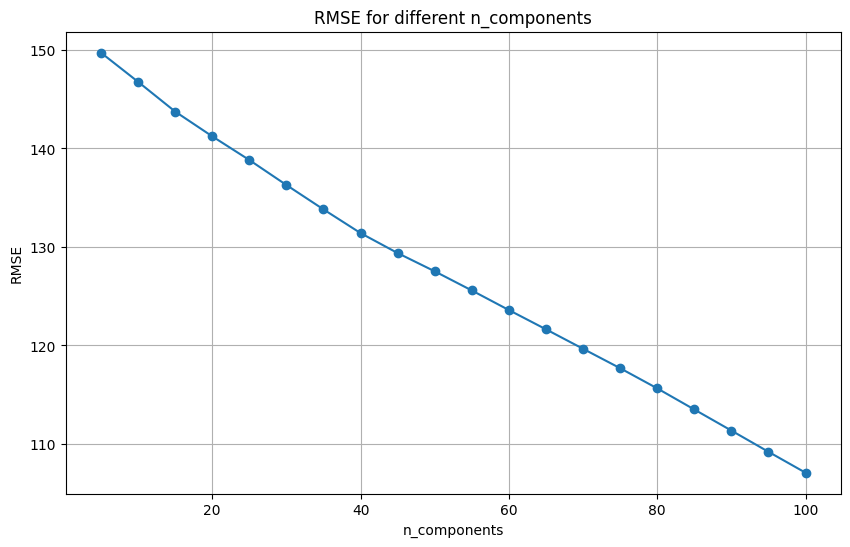

In [47]:
# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, rmse_scores, marker='o')
plt.title('RMSE for different n_components')
plt.xlabel('n_components')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

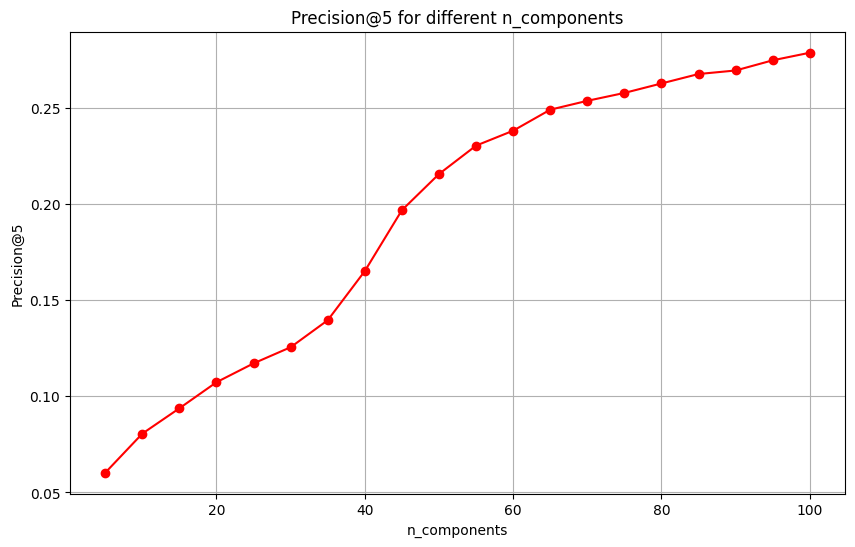

In [48]:
# Plot Precision@k
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, precision_scores, marker='o', color='r')
plt.title(f'Precision@{k} for different n_components')
plt.xlabel('n_components')
plt.ylabel(f'Precision@{k}')
plt.grid(True)
plt.show()

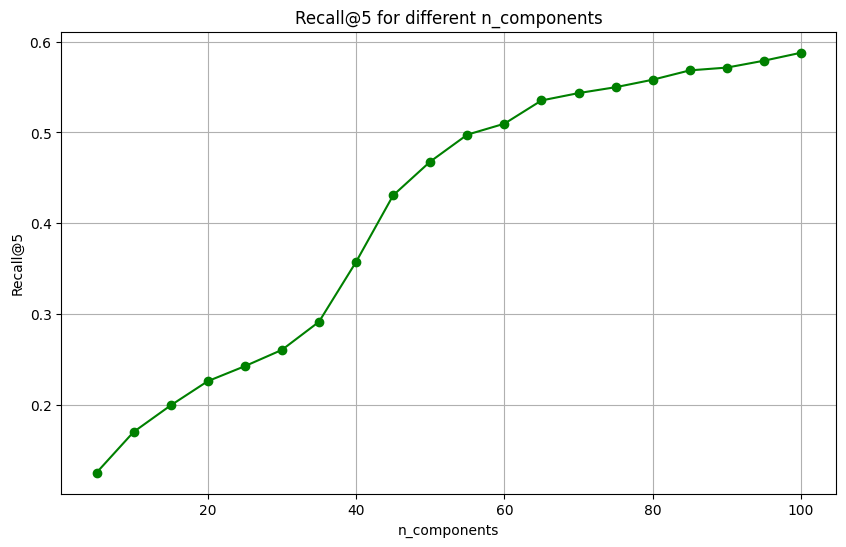

In [49]:
# Plot Recall@k
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, recall_scores, marker='o', color='g')
plt.title(f'Recall@{k} for different n_components')
plt.xlabel('n_components')
plt.ylabel(f'Recall@{k}')
plt.grid(True)
plt.show()

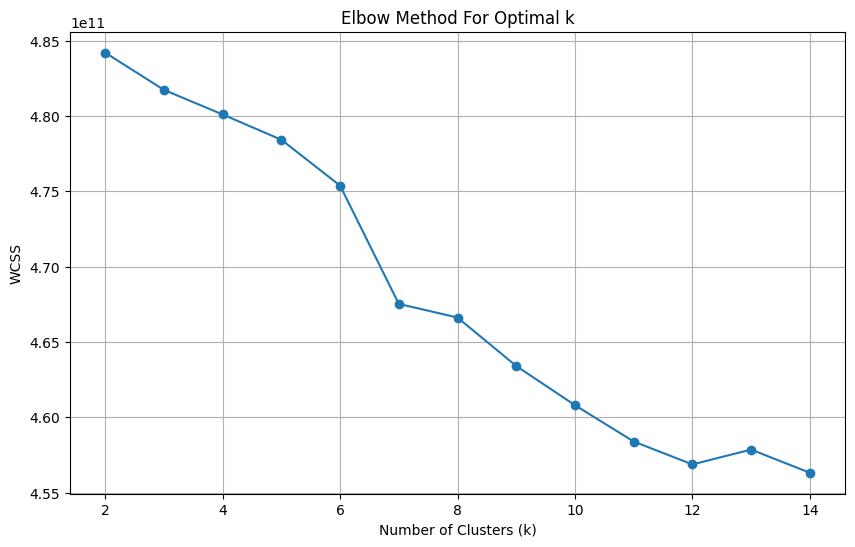

In [50]:
# Convert the sparse matrix to dense format for compatibility with KNN
train_dense = train_sparse.toarray()
test_dense = test_sparse.toarray()

# Assign new variable
X = train_dense

# Elbow method to find the optimal number of clusters
wcss = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

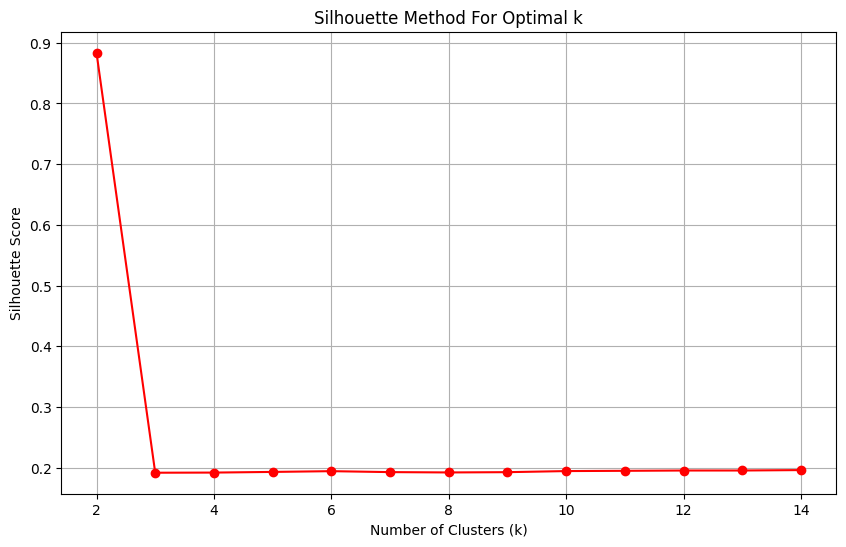

In [51]:
# Silhouette method to find the optimal number of clusters
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the Silhouette Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='r')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

KNN with k=2, RMSE=70.5559514365947, Precision@2=0.5982653389013813, Recall@2=0.6213959344540672


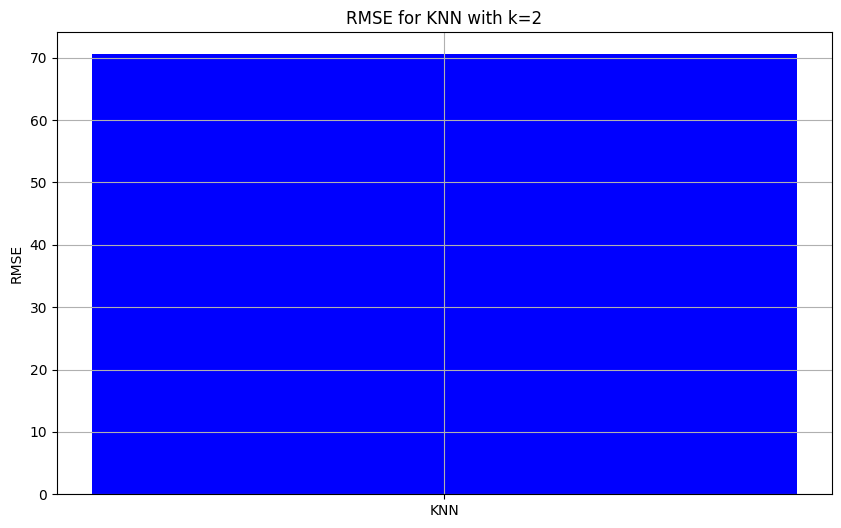

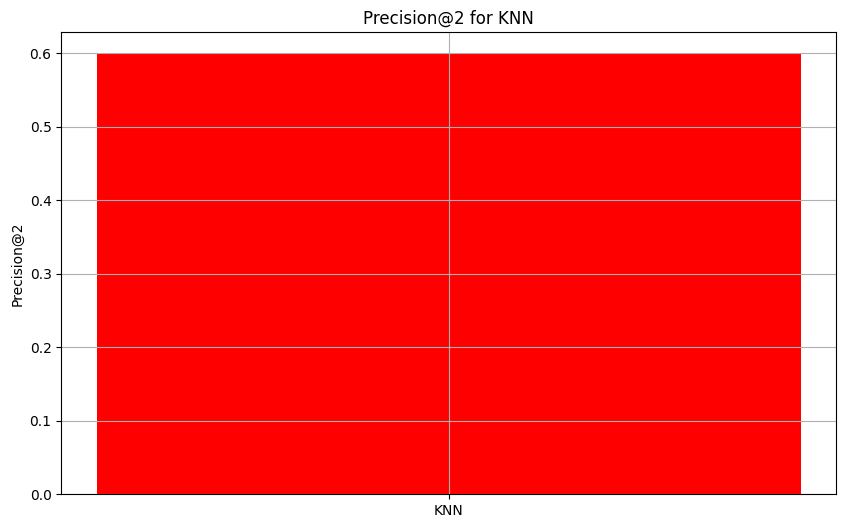

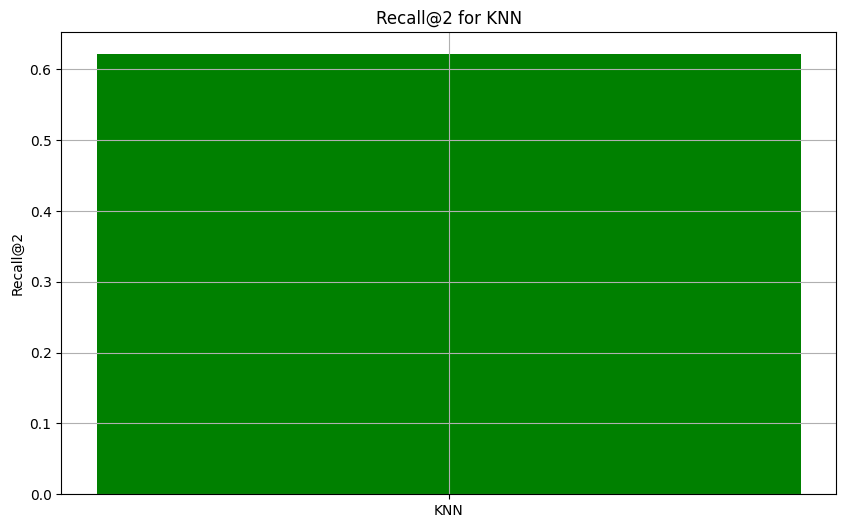

In [52]:
# Convert the sparse matrix to dense format for compatibility with KNN
train_dense = train_sparse.toarray()
test_dense = test_sparse.toarray()

# Define the number of neighbors for KNN
k = 2  # Using 2 clusters based on previous plots

# Initialize lists to store evaluation metrics
rmse_scores = []
precision_scores = []
recall_scores = []

# Define functions to calculate Precision@k and Recall@k
def precision_at_k(recommended_items, true_items, k):
    """Calculate Precision@k."""
    top_k_items = recommended_items[:k]
    true_positives = len(set(top_k_items) & set(true_items))
    precision = true_positives / k
    return precision

def recall_at_k(recommended_items, true_items, k):
    """Calculate Recall@k."""
    top_k_items = recommended_items[:k]
    true_positives = len(set(top_k_items) & set(true_items))
    recall = true_positives / len(true_items) if len(true_items) > 0 else 0
    return recall

# Perform KNN with the specified number of neighbors
knn = NearestNeighbors(n_neighbors=k, algorithm='auto')
knn.fit(train_dense)

# Reconstruct the training data using KNN
train_reconstructed = []
for user_ratings in train_dense:
    distances, indices = knn.kneighbors([user_ratings])
    similar_users = train_dense[indices.flatten()]
    user_reconstructed = similar_users.mean(axis=0)
    train_reconstructed.append(user_reconstructed)
train_reconstructed = np.array(train_reconstructed)

# Evaluate the model on the test set
test_reconstructed = []
for user_ratings in test_dense:
    distances, indices = knn.kneighbors([user_ratings])
    similar_users = train_dense[indices.flatten()]
    user_reconstructed = similar_users.mean(axis=0)
    test_reconstructed.append(user_reconstructed)
test_reconstructed = np.array(test_reconstructed)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_dense, test_reconstructed))
rmse_scores.append(rmse)

# Calculate Precision@k and Recall@k
precision_at_k_scores = []
recall_at_k_scores = []

for user_index in range(test_dense.shape[0]):
    user_ratings = test_dense[user_index, :]
    true_items = np.where(user_ratings > 0)[0]

    if len(true_items) == 0:
        continue

    user_reconstructed = test_reconstructed[user_index, :]
    recommended_items = np.argsort(user_reconstructed)[::-1]

    precision = precision_at_k(recommended_items, true_items, k)
    recall = recall_at_k(recommended_items, true_items, k)

    precision_at_k_scores.append(precision)
    recall_at_k_scores.append(recall)

mean_precision_at_k = np.mean(precision_at_k_scores)
mean_recall_at_k = np.mean(recall_at_k_scores)
precision_scores.append(mean_precision_at_k)
recall_scores.append(mean_recall_at_k)

print(f"KNN with k={k}, RMSE={rmse}, Precision@{k}={mean_precision_at_k}, Recall@{k}={mean_recall_at_k}")

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.bar(['KNN'], rmse_scores, color='b')
plt.title('RMSE for KNN with k=2')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Plot Precision@k
plt.figure(figsize=(10, 6))
plt.bar(['KNN'], precision_scores, color='r')
plt.title(f'Precision@{k} for KNN')
plt.ylabel(f'Precision@{k}')
plt.grid(True)
plt.show()

# Plot Recall@k
plt.figure(figsize=(10, 6))
plt.bar(['KNN'], recall_scores, color='g')
plt.title(f'Recall@{k} for KNN')
plt.ylabel(f'Recall@{k}')
plt.grid(True)
plt.show()

### Attempted numerous other variations of K values

In [53]:
# Convert the sparse matrix to dense format for compatibility with KNN
train_dense = train_sparse.toarray()
test_dense = test_sparse.toarray()

# Hyperparameter tuning for KNN
k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
rmse_scores = []
precision_scores = []
recall_scores = []

for k in k_values:
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto')
    knn.fit(train_dense)
    
    # Reconstruct the training data using KNN
    train_reconstructed = []
    for user_ratings in train_dense:
        distances, indices = knn.kneighbors([user_ratings])
        similar_users = train_dense[indices.flatten()]
        user_reconstructed = similar_users.mean(axis=0)
        train_reconstructed.append(user_reconstructed)
    train_reconstructed = np.array(train_reconstructed)
    
    # Evaluate the model on the test set
    test_reconstructed = []
    for user_ratings in test_dense:
        distances, indices = knn.kneighbors([user_ratings])
        similar_users = train_dense[indices.flatten()]
        user_reconstructed = similar_users.mean(axis=0)
        test_reconstructed.append(user_reconstructed)
    test_reconstructed = np.array(test_reconstructed)
    rmse = np.sqrt(mean_squared_error(test_dense, test_reconstructed))
    rmse_scores.append(rmse)
    
    # Calculate Precision@k and Recall@k
    precision_at_k_scores = []
    recall_at_k_scores = []
    
    for user_index in range(test_dense.shape[0]):
        user_ratings = test_dense[user_index, :]
        true_items = np.where(user_ratings > 0)[0]
        
        if len(true_items) == 0:
            continue
        
        user_reconstructed = test_reconstructed[user_index, :]
        recommended_items = np.argsort(user_reconstructed)[::-1]
        
        precision = precision_at_k(recommended_items, true_items, k)
        recall = recall_at_k(recommended_items, true_items, k)
        
        precision_at_k_scores.append(precision)
        recall_at_k_scores.append(recall)
    
    mean_precision_at_k = np.mean(precision_at_k_scores)
    mean_recall_at_k = np.mean(recall_at_k_scores)
    precision_scores.append(mean_precision_at_k)
    recall_scores.append(mean_recall_at_k)
    
    print(f"KNN k={k}, RMSE={rmse}, Precision@{k}={mean_precision_at_k}, Recall@{k}={mean_recall_at_k}")

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_scores, marker='o')
plt.title('RMSE for different k values in KNN')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Plot Precision@k
plt.figure(figsize=(10, 6))
plt.plot(k_values, precision_scores, marker='o', color='r')
plt.title(f'Precision@{k} for different k values in KNN')
plt.xlabel('k')
plt.ylabel(f'Precision@{k}')
plt.grid(True)
plt.show()

# Plot Recall@k
plt.figure(figsize=(10, 6))
plt.plot(k_values, recall_scores, marker='o', color='g')
plt.title(f'Recall@{k} for different k values in KNN')
plt.xlabel('k')
plt.ylabel(f'Recall@{k}')
plt.grid(True)
plt.show()

KNN k=5, RMSE=72.63444528179558, Precision@5=0.2591840668165757, Recall@5=0.647325989185102
KNN k=10, RMSE=75.10676798941542, Precision@10=0.1353035656922583, Recall@10=0.6610812636510794
KNN k=15, RMSE=76.37236019772747, Precision@15=0.09369311489452833, Recall@15=0.6738370992693754
KNN k=20, RMSE=77.14148779623463, Precision@20=0.07289110183103117, Recall@20=0.686872344998772
KNN k=25, RMSE=77.75210773118566, Precision@25=0.060461291358817865, Recall@25=0.7003476994591459
KNN k=30, RMSE=78.29637516760205, Precision@30=0.052003426491059, Recall@30=0.7116929884195456
KNN k=35, RMSE=78.81112259058885, Precision@35=0.04604653297232803, Recall@35=0.7245392672461944
KNN k=40, RMSE=79.32399377207975, Precision@40=0.04160777385159011, Recall@40=0.737267218344324
